# Introduction
Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, machine translation, robot control, video games, and healthcare. LSTM has become the most cited neural network of the 20th century.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs.

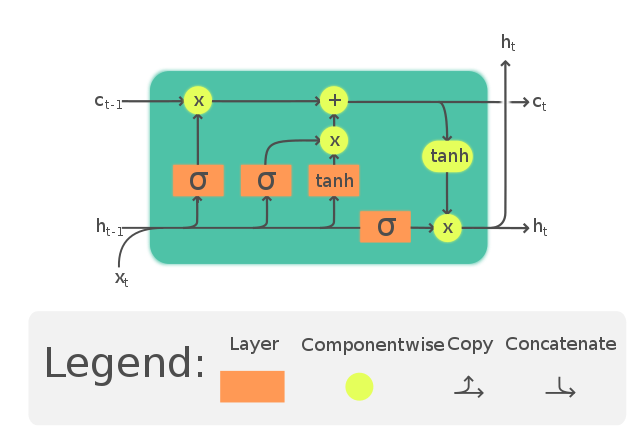

# Import Libraries

In [5]:
import warnings
warnings.filterwarnings("ignore")
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import psutil
psutil.cpu_times()
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import numpy as np
import time

# Functions for LSTM Forecasting

In [6]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m-%d %H:%M:%S')

# convert time series into supervised learning problem


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series


def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning


def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data


def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(
        n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,


def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model


def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
        
    return forecasts
    
# invert differenced forecast


def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts


def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step


def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset


def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# Load Data and Execute 

--- 342.2696876525879 seconds for model fitting ---
--- 20.567458152770996 seconds for forcast ---
t+1 RMSE: 3.272348


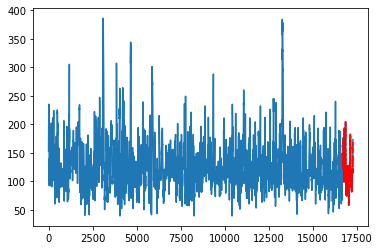

In [10]:
# load dataset
for i in range (1):

    series = read_csv(
        r'C:\Users\ahtis\OneDrive\Desktop\ARIMA\data\data.csv', header=0, index_col=0)
    series = series[0:17280]
    # configure
    n_lag = 1
    n_seq = 1
    n_test = 576
    n_epochs = 15
    n_batch = 1
    n_neurons = 50
    # prepare data
    scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
    
    # fit model
    start_time_fit_lstm = time.time()
    model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    print("--- %s seconds for model fitting ---" % (time.time() - start_time_fit_lstm))
    
    # make forecasts
    start_time_make_forecast = time.time()
    forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
    print("--- %s seconds for forecast ---" % (time.time() - start_time_make_forecast))
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
    actual = [row[n_lag:] for row in test]
    actual = inverse_transform(series, actual, scaler, n_test+2)
    # evaluate forecasts
    evaluate_forecasts(actual, forecasts, n_lag, n_seq)
    # plot forecasts
    plot_forecasts(series, forecasts, n_test+2)
    #series = series[0:len(series)+72,:]  


# Evaluate using RMSE

In [11]:
forecasts

[[array([138.08110201])],
 [array([135.04091418])],
 [array([135.77319705])],
 [array([134.99304152])],
 [array([136.60366118])],
 [array([136.43995309])],
 [array([138.12984419])],
 [array([139.7718544])],
 [array([139.77651298])],
 [array([143.32266271])],
 [array([143.04017186])],
 [array([141.99869549])],
 [array([138.75025892])],
 [array([142.1359597])],
 [array([134.56426597])],
 [array([138.72871494])],
 [array([136.10593772])],
 [array([139.71221495])],
 [array([138.17297602])],
 [array([134.88734889])],
 [array([135.44327533])],
 [array([132.31901979])],
 [array([132.92623478])],
 [array([128.45072079])],
 [array([133.64332771])],
 [array([126.06344891])],
 [array([128.39755249])],
 [array([129.73702812])],
 [array([140.58805346])],
 [array([143.96559596])],
 [array([148.69498634])],
 [array([152.62444162])],
 [array([161.58269453])],
 [array([167.3254962])],
 [array([166.95982242])],
 [array([171.97782898])],
 [array([165.68006325])],
 [array([163.06780577])],
 [array([154.35

In [12]:
actual

[[array([137.])],
 [array([135.])],
 [array([134.])],
 [array([135.])],
 [array([136.])],
 [array([137.])],
 [array([139.])],
 [array([137.])],
 [array([140.])],
 [array([143.])],
 [array([140.])],
 [array([135.])],
 [array([144.])],
 [array([143.])],
 [array([140.])],
 [array([134.])],
 [array([132.])],
 [array([137.])],
 [array([137.])],
 [array([140.])],
 [array([137.])],
 [array([130.])],
 [array([120.])],
 [array([133.])],
 [array([140.])],
 [array([134.])],
 [array([124.])],
 [array([129.])],
 [array([142.])],
 [array([148.])],
 [array([149.])],
 [array([155.])],
 [array([163.])],
 [array([157.])],
 [array([164.])],
 [array([170.])],
 [array([168.])],
 [array([158.])],
 [array([155.])],
 [array([152.])],
 [array([148.])],
 [array([146.])],
 [array([142.])],
 [array([141.])],
 [array([141.])],
 [array([144.])],
 [array([146.])],
 [array([146.])],
 [array([151.])],
 [array([148.])],
 [array([145.])],
 [array([148.])],
 [array([149.])],
 [array([147.])],
 [array([143.])],
 [array([1

## RMSE Calculation

In [13]:
import numpy as np
forecast = np.array(forecasts)
expected = np.array(actual)

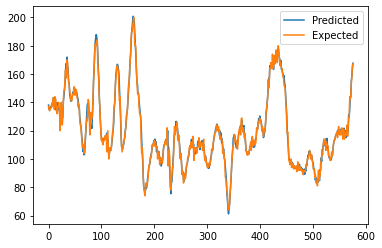

RMSE: 3.2723483785687417


In [14]:
pyplot.plot(forecast[:,0], label='Predicted')
pyplot.plot(expected[:,0], label='Expected')

pyplot.legend()
pyplot.show()
print ('RMSE:',(mean_squared_error(expected[:,0], forecast[:,0]))**0.5)

# Summary 
If we increase the number of iterations the MAE and RMSE is almost constant, with slight up and down variations based on particular input data. The model is behaving good in terms of accuracy and is able to capture future prediction trends. 

## Suggestions

1. Increasing the input dataset may(not necessarily) decrease the overall error rate.
2. Model is performing good enough and can be deployed in a practical scenario on test trials for further evaluation. 

